**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol':'BTCUSDT:binance','freq': '30Min,1H','start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

4.7356812953948975


In [3]:
#调用模块
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

In [4]:
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [5]:
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap30 = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

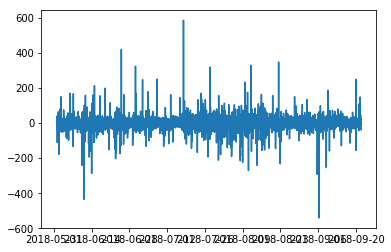

In [6]:
#30min的图
import matplotlib.pyplot as plt
plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

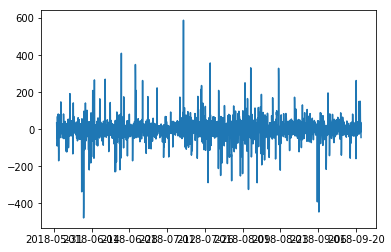

In [7]:
#1H的图
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [8]:
import warnings

warnings.filterwarnings('ignore')

In [9]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

5.881537199020386


In [10]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv30M = HFDataView()
dv1H = HFDataView()

In [11]:
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [12]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [13]:
import matplotlib.pyplot as plt
def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=5, LongPeriod=20, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [14]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha10_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

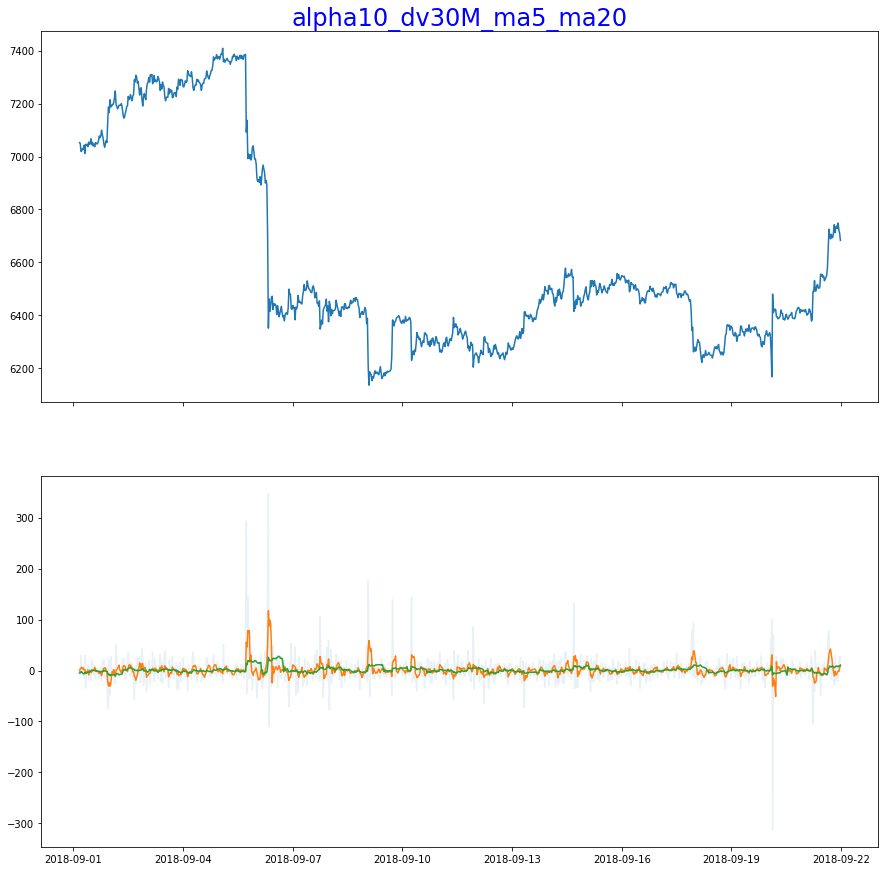

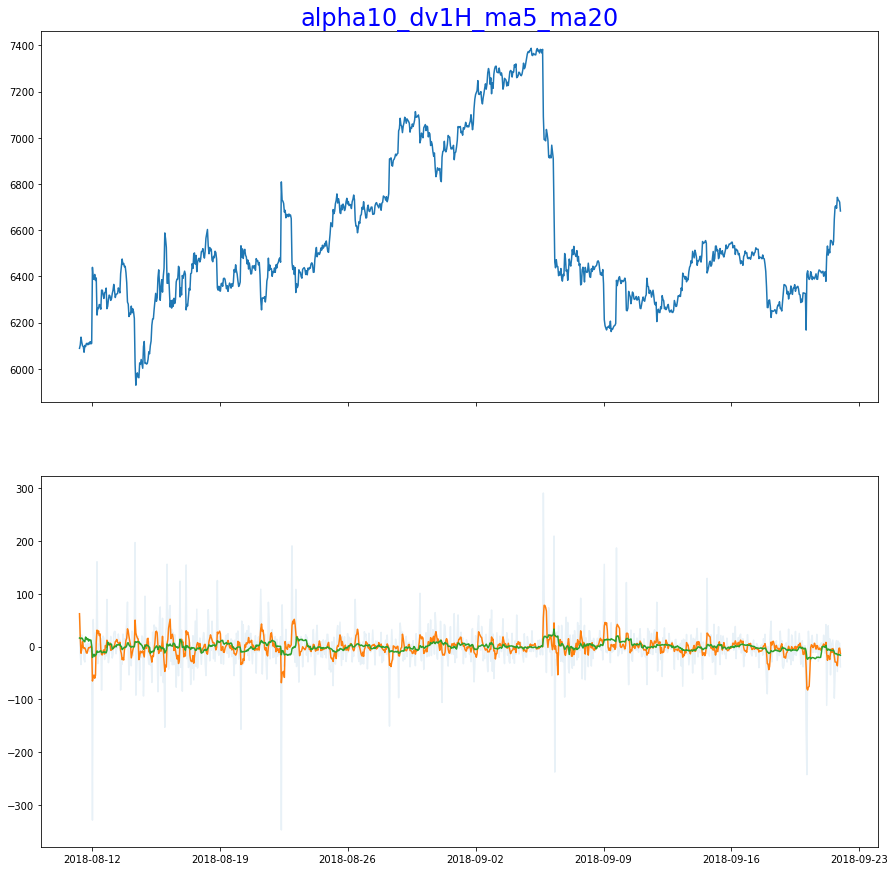

In [15]:
import pandas as pd
for name, alpha in alpha10_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)

In [16]:
# 进场信号
long = dv1H.add_formula("long","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("short","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

In [17]:
dv1H.get_ts('long').stack()[dvAdd.get_ts('long').stack()==2].tail(5)

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [18]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
alpha10Ma = TimingDigger(output_folder="./output", output_format='pdf',signal_name='alpha10')
TimingSignal(alpha10Ma, dv1H, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [19]:
alpha10Ma.create_event_report(sig_type="long_short") #同时计算多空头信号的绩效#(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [20]:
import warnings

warnings.filterwarnings('ignore')

In [21]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

4.497040271759033


In [22]:
data1H = Time_dict.set_index('datetime')

In [23]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()

In [24]:
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [25]:
def location(df):
    Location = (df.close-df.low.rolling(50).min())/(df.high.rolling(50).max()-df.low.rolling(50).min())*100
    return Location

Location = location(data1H)

In [26]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [27]:
ms = dv1H.add_formula('ms', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
msVolume = dv1H.get_ts('ms', date_type='datetime')

In [28]:
msVolume[msVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


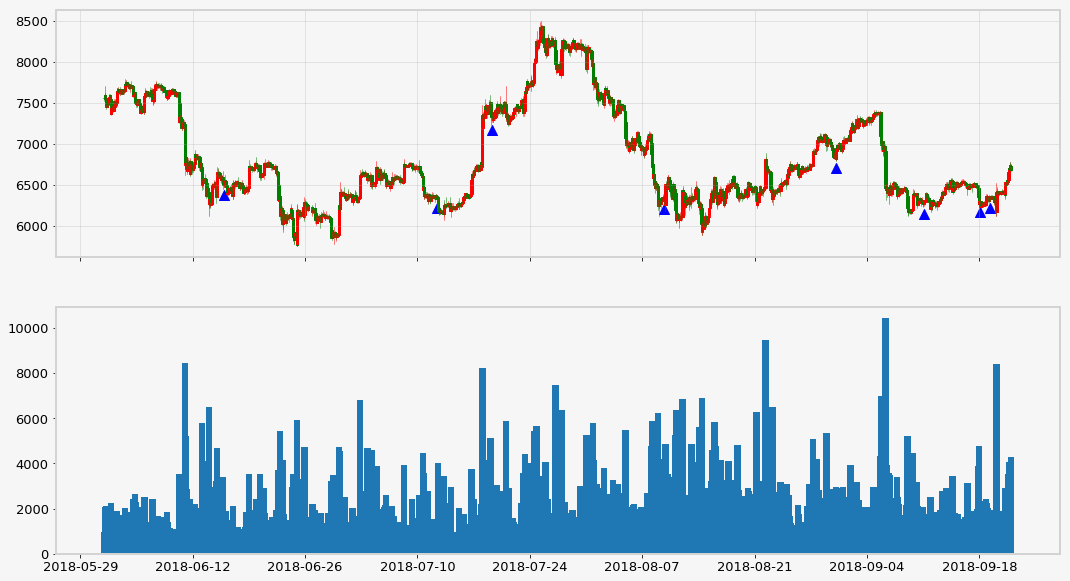

In [29]:
msVolumeX = msVolume[msVolume['BTCUSDT:binance']==100].index
msVolumeY = data1H.loc[msVolumeX].low-100
draw_candle(candle, msVolumeX, msVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [1]:
# 因子01：alpha08

import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, alpha, chart_name='dv_alpha08_ma', ShortPeriod=20, LongPeriod=55, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax2 = ax.twinx()
    ax2.plot(alpha.iloc[n:], alpha=0.2)
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    ax3 = ax1.twinx()
    ax3.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],alpha=0.5)
    plt.show()

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('alpha08_C',"-1*((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5))-Delay((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5)),10))",add_data=True).tail(10)

Initialize dataview success.


symbol,BTCUSDT:binance
trade_date,
20180921140000,-438.824497
20180921150000,-117.783214
20180921160000,-75.799267
20180921170000,-359.557739
20180921180000,-312.847803
20180921190000,-340.719524
20180921200000,-93.405574
20180921210000,-14.881189
20180921220000,202.932376


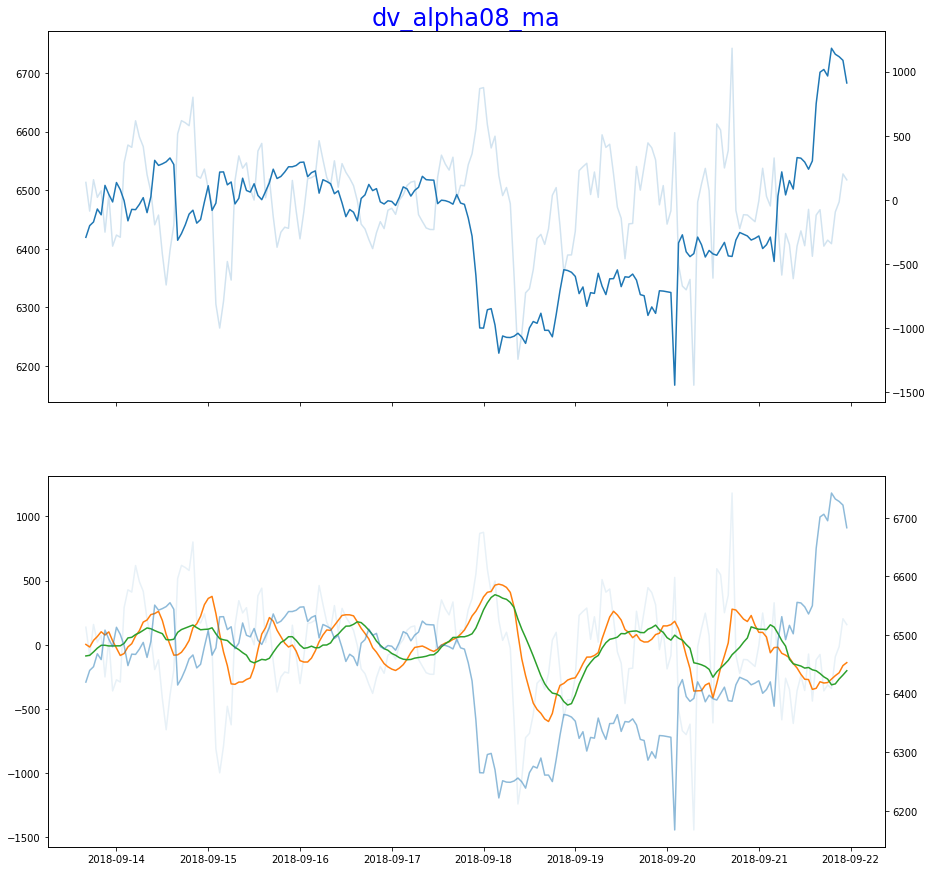

In [2]:
alpha = dv1H.get_ts('alpha08_C', date_type='datetime')
Plot_Mean(dv1H, alpha.iloc[:,0], chart_name='dv_alpha08_ma',ShortPeriod=10, LongPeriod=15, n=-200)

In [3]:
#研究报告
##因子：alpha08 
##公式：-1*((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5))-Delay((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5)),10))
##线 ：橘色为alpha08的10日短线，绿色为alpha08的15日长线，蓝色为此时间段内股价的走势，浅蓝色为alpha08此区间内的走势
##现象：可以发现alpha08的走势与股价的走势几乎是呈现镜像的，alpha与股价存在较强的反向关系

In [19]:
# 因子02：MACD

import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) 

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, MACD, Diff, Dea, chart_name='dv_MACD', n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax2 = ax.twinx()
    ax2.plot(MACD.iloc[n:], alpha=0.2)
    ax1.plot(Diff.iloc[n:], alpha=1,color='y')
    ax1.plot(Dea.iloc[n:], alpha=1,color='g')
    ax3 = ax1.twinx()
    ax3.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],alpha=0.5)
    plt.show()

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('Diff_J',"Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26)", add_data=True)
dv1H.add_formula('Dea_J',"Ta('EMA',0,0,0,0,Diff_J,0,9)", add_data=True)
dv1H.add_formula('MACD_J',"(Diff_J-Dea_J)*2",add_data=True).tail(10)

Initialize dataview success.


symbol,BTCUSDT:binance
trade_date,
20180921140000,13.972742
20180921150000,23.550096
20180921160000,34.424801
20180921170000,39.243184
20180921180000,37.906912
20180921190000,40.158234
20180921200000,37.103233
20180921210000,31.566276
20180921220000,24.430337


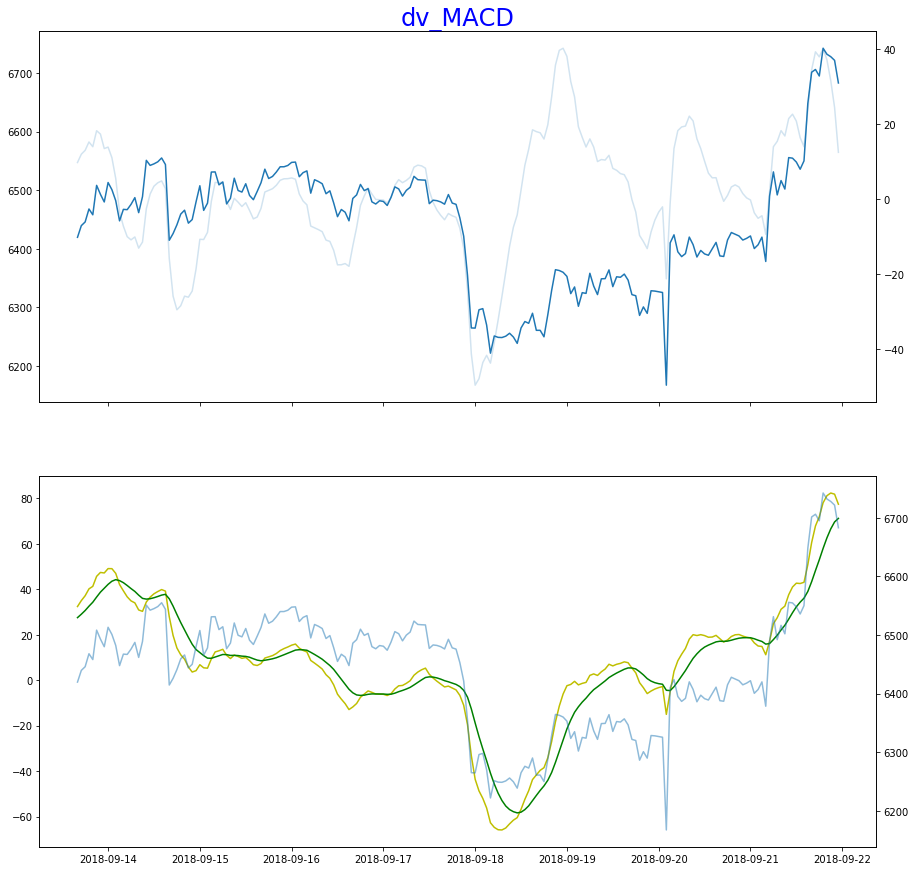

In [5]:
MACD = dv1H.get_ts('MACD_J', date_type='datetime')
Diff = dv1H.get_ts('Diff_J', date_type='datetime')
Dea = dv1H.get_ts('Dea_J', date_type='datetime')

# 橘色短线 绿色长线
Plot_Mean(dv1H, MACD.iloc[:,0], Diff.iloc[:,0], Dea.iloc[:,0], n=-200)

In [6]:
#研究报告
##因子：MACD 
##公式：Diff_J=Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26),Dea_J=Ta('EMA',0,0,0,0,Diff_J,0,9),MACD_J=(Diff_J-Dea_J)*2
##描述：MACD称为异同移动平均线，是从双指数移动平均线发展而来的，由快的指数移动平均线（EMA12）减去慢的指数移动平均线（EMA26）得到快线DIF，再用2×（快线DIF-DIF的9日加权移动均线DEA）得到MACD柱。
## 线：黄色线为快的指数移动平均线（EMA12），绿色线为慢的指数移动平均线（EMA26），蓝色为此时间段内股价的走势
##现象：可以发现MACD线同股价的走势一致，比较平滑的，一般反应的的是较长期的趋势

In [1]:
#因子03：ASI
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, asi, chart_name='dv_asi', ShortPeriod=10, LongPeriod=15, n=-200):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax2 = ax.twinx()
    ax2.plot(asi.iloc[n:], alpha=0.2)
    ax1.plot(asi.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(asi.rolling(ShortPeriod).mean(), index=asi.index).iloc[n:])
    ax1.plot(pd.Series(asi.rolling(LongPeriod).mean(), index=asi.index).iloc[n:])
    ax3 = ax1.twinx()
    ax3.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],alpha=0.5)
    plt.show()

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('AA',"Abs(Delta(close,1))",add_data=True)
dv1H.add_formula('BB',"Abs(low-Delay(close,1))",  add_data=True)
dv1H.add_formula('CC',"Abs(high-Delay(low,1))", add_data=True)
dv1H.add_formula('DD',"Abs(Delay(close,1)-Delay(open,1))", add_data=True)
dv1H.add_formula('EE',"Delta(close,1)", add_data=True)
dv1H.add_formula('FF',"close-open", add_data=True)
dv1H.add_formula('GG',"Delay(close,1)-Delay(open,1)",  add_data=True)
dv1H.add_formula('XX',"EE+FF/2+GG",add_data=True)
dv1H.add_formula('KK',"Max(AA,BB)",  add_data=True)
dv1H.add_formula('RR',"If(AA>Max(BB,CC),AA+BB/2+DD/4,If(BB>Max(AA,CC),AA/2+BB+DD/4,CC+DD/4))",add_data=True)
dv1H.add_formula('SI',"16*XX/RR*KK", add_data=True)

dv1H.add_formula('ASI_J', "Ts_Sum(SI,20)", add_data=True).tail(10)

Initialize dataview success.


symbol,BTCUSDT:binance
trade_date,
20180921140000,1341.624130
20180921150000,2853.423782
20180921160000,3491.043361
20180921170000,3873.060707
20180921180000,3845.459857
20180921190000,4373.827545
20180921200000,4652.227867
20180921210000,4955.465392
20180921220000,4828.913396


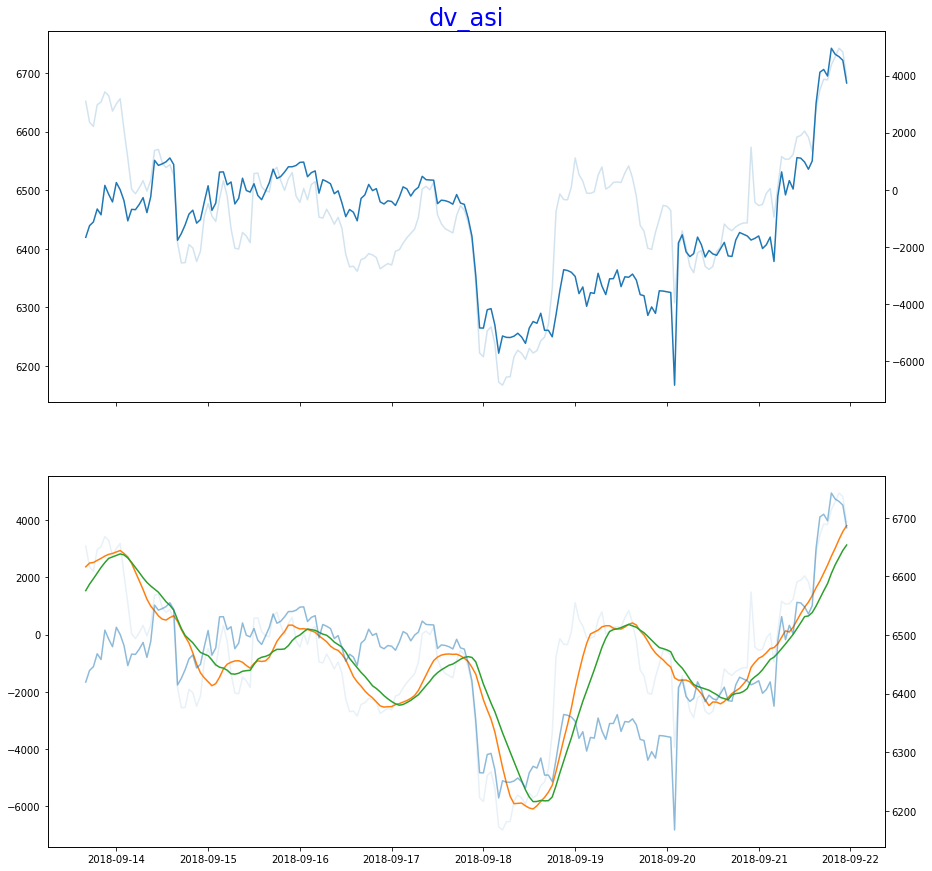

In [2]:
asi = dv1H.get_ts('ASI_J', date_type='datetime')
Plot_Mean(dv1H, asi.iloc[:,0], chart_name='dv_asi',ShortPeriod=10, LongPeriod=15, n=-200)
#橘色短线 绿色长线

In [3]:
#研究报告
##因子：ASI
##描述：振动升降指标(ASI)，由威尔斯·王尔德（Welles Wilder）所创。ASI指标以开盘、最高、最低、收盘价与前一交易日的各种价格相比较作为计算因子。
## 线：黄色线为ASI的10日移动平均线，绿色线为ASI的15日移动平均线，蓝色为此时间段内股价的走势
##现象：可以发现ASI线同股价的走势一致，比较平滑的，一般反应的的是较长期的趋势

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

In [7]:
#进出场条件：由于alpha08与股价走势存在着相反的关系，所以由观察所得的入场条件
##因子：alpha08 
##公式：RANK(DELTA(((((HIGH + LOW) / 2) * 0.2) + (VWAP * 0.8)), 4) * -1)
##进场：当alpha08的10日短线下穿15日长线时买入
##出场：当alpha08的10日短线上穿15日长线时卖出

In [8]:
#进出场条件：由以上观察
##因子：MACD
##进场：当黄色线上传绿色线（短线上传长线）时买入
##出场：当黄色线下穿绿色线（短线下穿长线）时卖出

In [4]:
#进出场条件：由以上观察
##因子：ASI
##进场：当黄色线上传绿色线（短线上传长线）时买入
##出场：当黄色线下穿绿色线（短线下穿长线）时卖出

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


In [9]:
#因子alpha08的绩效

In [11]:
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, alpha, chart_name='dv_alpha08_ma', ShortPeriod=20, LongPeriod=55, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax2 = ax.twinx()
    ax2.plot(alpha.iloc[n:], alpha=0.2)
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    ax3 = ax1.twinx()
    ax3.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],alpha=0.5)
    plt.show()

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('alpha08_C',"-1*((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5))-Delay((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5)),10))",add_data=True).tail(10)

Initialize dataview success.


symbol,BTCUSDT:binance
trade_date,
20180921140000,-438.824497
20180921150000,-117.783214
20180921160000,-75.799267
20180921170000,-359.557739
20180921180000,-312.847803
20180921190000,-340.719524
20180921200000,-93.405574
20180921210000,-14.881189
20180921220000,202.932376


In [12]:
# 进场信号
long = dv1H.add_formula("longAlpha08","If((Ts_Mean(alpha08_C,10)<Ts_Mean(alpha08_C,15)) && (Delay(Ts_Mean(alpha08_C,10),1)>=Delay(Ts_Mean(alpha08_C,15),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha08","If((Ts_Mean(alpha08_C,10)>Ts_Mean(alpha08_C,15)) && (Delay(Ts_Mean(alpha08_C,10),1)<=Delay(Ts_Mean(alpha08_C,15),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha08","If(shortAlpha08==2,-1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha08","If(longAlpha08==-2,1,0)", add_data=True)

In [13]:
dv1H.get_ts('longAlpha08').stack()[dv1H.get_ts('longAlpha08').stack()==2].tail()

trade_date      symbol         
20180918090000  BTCUSDT:binance    2.0
20180919140000  BTCUSDT:binance    2.0
20180920040000  BTCUSDT:binance    2.0
20180921000000  BTCUSDT:binance    2.0
20180921100000  BTCUSDT:binance    2.0
dtype: float64

In [14]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [15]:
from jaqs_fxdayu.research import TimingDigger
tdAlpha08 = TimingDigger(output_folder="./output08", output_format='pdf',signal_name='Alpha008')
TimingSignal(tdAlpha08, dv1H,'longAlpha08','shortAlpha08','closeLongAlpha08','closeShortAlpha08', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [16]:
tdAlpha08.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               9.150 -19.509    0.117
p-value              0.000   0.000    0.907
mean                 0.048  -0.045    0.001
std                  0.044   0.020    0.058
info_ratio           1.071  -2.253    0.010
skewness             1.722   0.912    0.989
kurtosis             2.373  -0.317    0.965
pct5                 0.007  -0.069   -0.065
pct25                0.018  -0.058   -0.053
pct50                0.033  -0.053   -0.002
pct75                0.054  -0.031    0.033
pct95                0.163  -0.003    0.110
occurance           74.000  76.000  150.000
win_ratio              NaN     NaN    0.493
win_mean/loss_mean     NaN     NaN    1.052


In [17]:
tdAlpha08.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat              11.253 -18.562    1.173
p-value              0.000   0.000    0.242
mean                 0.059  -0.042    0.006
std                  0.044   0.020    0.060
info_ratio           1.336  -2.075    0.095
skewness             0.361   0.529    0.672
kurtosis            -0.783  -0.778   -0.616
pct5                 0.001  -0.064   -0.062
pct25                0.018  -0.055   -0.052
pct50                0.064  -0.051   -0.005
pct75                0.093  -0.028    0.046
pct95                0.125  -0.005    0.111
occurance           72.000  81.000  153.000
win_ratio              NaN     NaN    0.471
win_mean/loss_mean     NaN     NaN    1.419


In [18]:
tdAlpha08.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               14.344  -26.881    0.933
p-value               0.000    0.000    0.352
mean                  0.053   -0.043    0.003
std                   0.045    0.020    0.059
info_ratio            1.191   -2.152    0.054
skewness              1.030    0.705    0.823
kurtosis              0.468   -0.615    0.084
pct5                  0.003   -0.069   -0.063
pct25                 0.018   -0.056   -0.052
pct50                 0.039   -0.052   -0.002
pct75                 0.083   -0.029    0.038
pct95                 0.143   -0.004    0.114
occurance           146.000  157.000  303.000
win_ratio               NaN      NaN    0.482
win_mean/loss_mean      NaN      NaN    1.227
